In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from skimage.color import rgb2gray
import h5py

# Description 

We experiment with magnification level 4 in this notebook. 

The evaluation metrics we use are: accuracy, precision, recall. 

Recall is especially important since in detecting cancer, we would rather have false positives than false negatives. (It is better to misdiagnose a person as having cancer since this can be rectified but missibng that someone has cancer is a much more serious error). 

The data already had more than 15,000 tumor images, and thus was not augmented. We only test with the original data. We will compare transfer learning and CNNs, at level 4 and also compare the results in brief with level 5. 

# Downloading saved data

We download the data and split into training and validation. 

In [0]:
level = 4
slide_subimages_loaded = np.load('train_subimages' +  str(level) +'.npy')
slide_sublabels_loaded = np.load('train_labels' + str(level) + '.npy')

In [0]:
print("training shape", slide_subimages_loaded.shape)
print("labels shape", slide_sublabels_loaded.shape)

training shape (58130, 150, 150, 3)
labels shape (58130,)


In [0]:
X_train, X_val, y_train, y_val = train_test_split(slide_subimages_loaded, slide_sublabels_loaded, test_size=0.33, random_state=42)

# Model Building

We first delete unnecessary objects to save memory. Next we define helper functions. 

In [0]:
del slide_subimages_loaded, slide_sublabels_loaded 

In [0]:
import tensorflow
from keras import models
from keras import layers
from keras import applications

print("X_train", X_train.shape)
print("X_val", X_val.shape)

print("y_train", y_train.shape)
print("y_val", y_val.shape)

X_train (38947, 150, 150, 3)
X_val (19183, 150, 150, 3)
y_train (38947,)
y_val (19183,)


Using TensorFlow backend.


In [0]:
# reads the slide into a numpy array depending on the level we select
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
#we find the tissue percentage in each patch. If there are np tissues (or very little), we ignore the patch since it 
# won't be very useful to us
def find_tissue_percentage(slide_region, window_size):
    
    image_width = window_size
    image_height = window_size

    def find_tissue_pixels(image, intensity=0.8):
        im_gray = rgb2gray(image)
        assert im_gray.shape == (image.shape[0], image.shape[1])
        indices = np.where(im_gray <= intensity)
        return list(zip(indices[0], indices[1]))
    
    tissue_pixels = find_tissue_pixels(slide_region)
    percent_tissue = len(tissue_pixels) / float(image_width * image_height) * 100
    
    return percent_tissue


# We use this function to see if there is any cancer. We do this by seeing if any pixels in the mask are non-zero in 
# the region we are examining (given by patch_centre)
def check_if_cancer(patch_mask, patch_centre):
    patch_size = patch_mask.shape[0]
    offset = int((patch_size-patch_centre)/2)
    sum_vals = np.sum(patch_mask[offset:offset+patch_centre, offset:offset+patch_centre])
    return sum_vals>0

# **Transfer Learning**

We start by using transfer learning (InceptionV3) on the skewed dataset. We get a 94% validation accuracy. We only run the training for three epochs, since we don't want to overfit the data. 

In [0]:
window_size = 150
level = 4
stride = 20

conv_base = applications.inception_v3.InceptionV3(weights='imagenet',
                                        include_top=False,
                                        input_shape=(window_size, window_size, 3))

model_tr = models.Sequential()
model_tr.add(conv_base)
model_tr.add(layers.Flatten())
model_tr.add(layers.Dense(256, activation='relu'))
model_tr.add(layers.Dropout(.5))
model_tr.add(layers.Dense(1, activation='sigmoid'))


print('Number of trainable layers:', len(model_tr.trainable_weights))

model_tr.summary()

Number of trainable layers: 192
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 26,487,457
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
from keras import optimizers

model_tr.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model_tr.fit(X_train,
          y_train,
          epochs=3,
          batch_size=128,
          validation_data=(X_val, y_val))
model_tr.save('model_level4_transfer.h5')

Train on 38947 samples, validate on 19183 samples
Epoch 1/3
38947/38947 [==============================] - 130s 3ms/step - loss: 0.1573 - acc: 0.9342 - val_loss: 0.0445 - val_acc: 0.9823

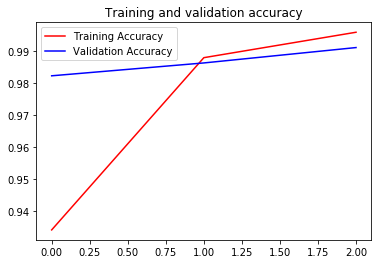

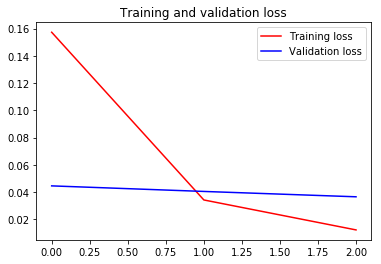

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# To get patches for testing, we don't need to return the mask. 
def get_patches_from_images_for_testing(slide, mask, level, window_size, stride):
    
    tissue_threshold = 0.01
    image_deck = []
    mask_labels = []
    
    #At slide level
    image_width = slide.level_dimensions[level][0]
    image_height = slide.level_dimensions[level][1]
    
    x_c = 0
    y_c = 0
    downsample_factor = int(slide.level_downsamples[level]) #2**level
    
    # Move window through the slide
    while y_c < (image_height - window_size + 1):
        while x_c < (image_width - window_size + 1):
            
            # slide image
            slide_region = read_slide(slide, 
                         x= x_c * downsample_factor, 
                         y= y_c * downsample_factor, 
                         level= level, 
                         width= window_size, 
                         height= window_size)
            
            # mask image
            mask_region = read_slide(mask, 
                         x= x_c * downsample_factor, 
                         y= y_c * downsample_factor, 
                         level= level, 
                         width= window_size, 
                         height= window_size)
            
            mask_region = mask_region[:,:,0]

            cancer_present= check_if_cancer(mask_region, 50)
            image_deck.append(slide_region)
            if cancer_present:
                mask_labels.append(1)
            else:
                mask_labels.append(0)
                  
            # move by stride
            x_c += stride
        
        # end of row, reset and move down by stride
        x_c = 0
        y_c += stride
    return image_deck, mask_labels

In [0]:
# We find the test patches for each test slide. We then evaluate our model based on predictions and return them
def get_test_image(test_path, test_mask_path, model):
    test_images = []
    test_masks = []

    test_images.append(open_slide(test_path))
    test_masks.append(open_slide(test_mask_path))
    subimages, sublabels = get_patches_from_images_for_testing(test_images[0], test_masks[0], level, window_size, stride)

    X_test = []
    y_test = []

    X_test.extend(subimages)
    y_test.extend(sublabels)

    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
    
    print(X_test.shape)

    predictions = model.predict(X_test)

    test_loss, test_acc = model.evaluate(X_test, y_test)
    print('test acc score:', test_acc)
    return X_test, y_test, predictions, test_images, test_masks

In [0]:
def ret_slide(slide_name):
    slide_object = open_slide(slide_name)
    width = slide_object.level_dimensions[level][0]
    height = slide_object.level_dimensions[level][1]

    image_result = read_slide(slide_object, 
                                x=0, 
                                y=0, 
                                level=level, 
                                width=width, 
                                height=height)
    return image_result

#This is to overlay the heatmap with the actual image
def overlay(slide_name, level, predicted_mask):
    image_result = ret_slide(slide_name)
    if "mask" in slide_name:
        image_result = image_result[:,:,0]
    
    plt.figure(figsize=(10,10), dpi=100)
    plt.imshow(image_result,alpha=0.75)
    plt.imshow(predicted_mask, cmap='jet', alpha=0.5)

In [0]:
def get_mask(slide_name, level):
    image_result = ret_slide(slide_name)
    image_result = image_result[:,:,0] 
    return image_result

In [0]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, precision_score, confusion_matrix
def calc_metrics(y_test,predictions, thresh = 0.8):
    true_class = y_test
    pred_class = predictions
    
    roc_auc = roc_auc_score(np.array(true_class) == 1, pred_class)

    precision = precision_score(np.array(true_class) == 1, np.array(pred_class) >=  thresh)
    recall = recall_score(np.array(true_class) == 1, np.array(pred_class) >=  thresh)
    f1 = f1_score(np.array(true_class) == 1, np.array(pred_class) >=  thresh)

    print('Precision score: %.3f' % precision)
    print('Recall score: %.3f' % recall)
    print('F1 score: %.3f' % f1)
    print('ROC AUC score: %.3f' % roc_auc)

    print(confusion_matrix(np.array(true_class) == 1, np.array(pred_class) >=  thresh))

In [0]:
def get_heatmap(test_images, predictions, model, threshold=0.8):
    width = test_images[0].level_dimensions[level][0]
    height = test_images[0].level_dimensions[level][1]

    predicted_mask = np.zeros((height, width))

    x_c = 0
    y_c = 0

    for p in predictions:
        if p > threshold:
            predicted_mask[int(y_c + (window_size / 2) - (stride / 2)):int(y_c + (window_size / 2) + (stride / 2)), 
                           int(x_c + (window_size / 2) - (stride / 2)):int(x_c + (window_size / 2) + (stride / 2))] = 1

        x_c+= stride
        if x_c > (width - window_size):
            x_c = 0
            y_c += stride
            
    return predicted_mask



## Experiment 1 

*Transfer learning with dataset*

We test our model on three slides : 091, 110, 096 (in that order)

For each test image, the predicted mask is shown first, next the actual mask, and finally the slide with the heatmap overlaid. 

### TEST 1

#### Predicted mask shown below :

(34056, 150, 150, 3)
34056/34056 [==============================] - 40s 1ms/step

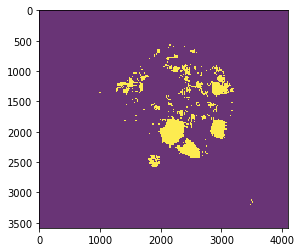

In [0]:
X_test, y_test, predictions, test_images, test_masks = get_test_image('./tumor_091.tif','./tumor_091_mask.tif',model_tr)
calc_metrics(y_test,predictions)
predicted_mask = get_heatmap(test_images, predictions, model_tr)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)

#### Actual mask shown below :

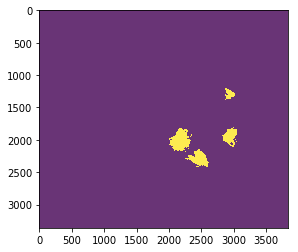

In [0]:
mask_region = get_mask('./tumor_091_mask.tif',5)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)

#### Overlaid image show below :

The cancer is the red area. 

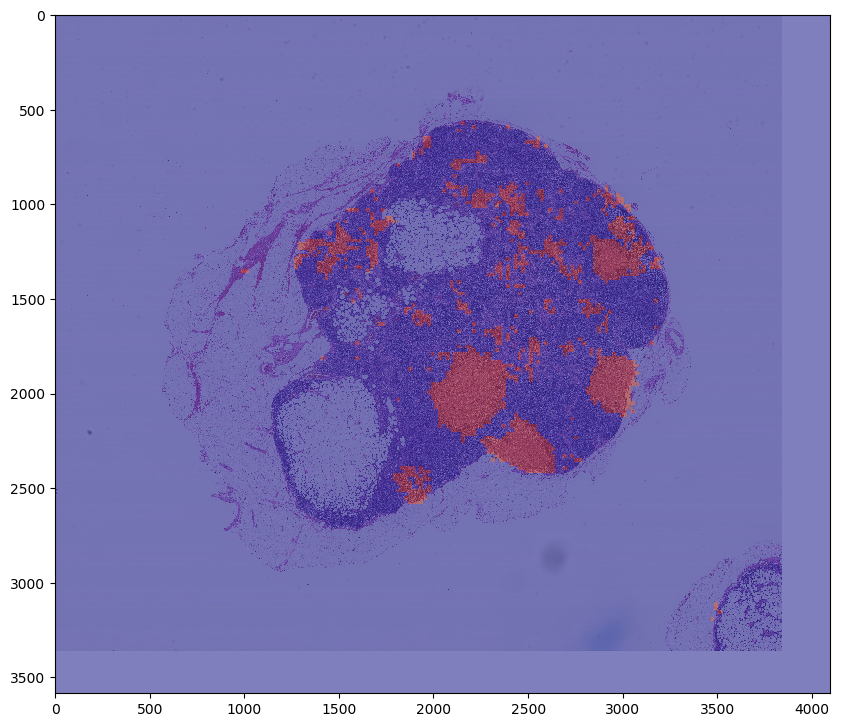

In [0]:
overlay('../vatsala-adl/tumor_091.tif', 5, predicted_mask )

### TEST 2

(66900, 150, 150, 3)
66900/66900 [==============================] - 77s 1ms/step

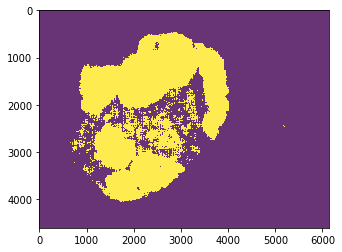

In [0]:
X_test, y_test, predictions, test_images, test_masks = get_test_image('../vatsala-adl/tumor_110.tif','../vatsala-adl/tumor_110_mask.tif',model_tr)
calc_metrics(y_test,predictions)
predicted_mask = get_heatmap(test_images, predictions, model_tr)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)

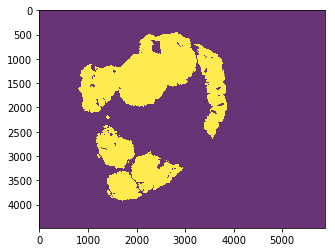

In [0]:
mask_region = get_mask('../vatsala-adl/tumor_110_mask.tif',5)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)

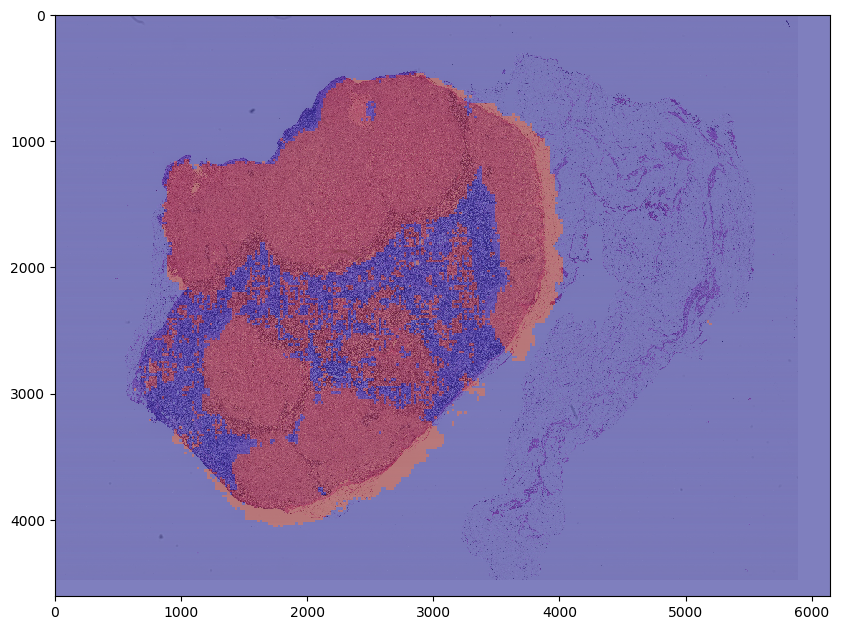

In [0]:
overlay('../vatsala-adl/tumor_110.tif', 4, predicted_mask )

### TEST 3

In [0]:
X_test, y_test, predictions, test_images, test_masks = get_test_image('../vatsala-adl/tumor_096.tif','../vatsala-adl/tumor_096_mask.tif',model_tr)
calc_metrics(y_test,predictions)

(89869, 150, 150, 3)
89869/89869 [==============================] - 103s 1ms/step

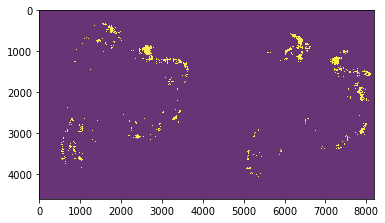

In [0]:
predicted_mask = get_heatmap(test_images, predictions, model_tr)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)

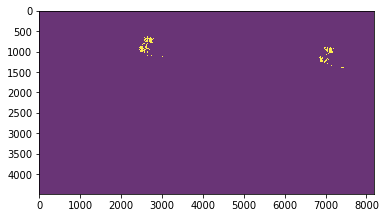

In [0]:
mask_region = get_mask('../vatsala-adl/tumor_096_mask.tif',5)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)

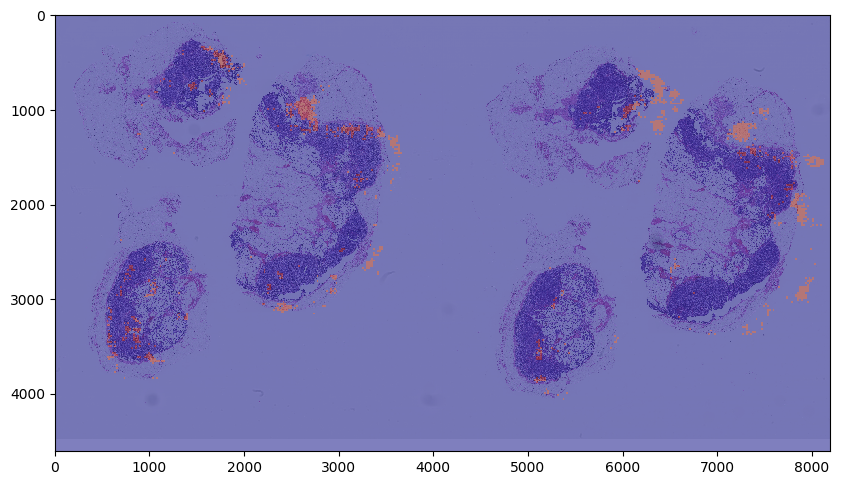

In [0]:
overlay('../vatsala-adl/tumor_096.tif', 5, predicted_mask )

# Convolution experiments

## Experiment 2

*CNNs with the dataset*

We test our model on three slides : 091, 110, 096 (in that order)

For each test image, the predicted mask is shown first, next the actual mask, and finally the slide with the heatmap overlaid. 

In [0]:
model_conv_scratch = models.Sequential()
model_conv_scratch.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(window_size, window_size, 3)))
model_conv_scratch.add(layers.MaxPooling2D((2, 2)))

model_conv_scratch.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv_scratch.add(layers.MaxPooling2D((2, 2)))

model_conv_scratch.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv_scratch.add(layers.MaxPooling2D((2, 2)))

model_conv_scratch.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_conv_scratch.add(layers.MaxPooling2D((2, 2)))

model_conv_scratch.add(layers.Flatten())
model_conv_scratch.add(layers.Dense(128, activation='relu'))
model_conv_scratch.add(layers.Dense(1, activation='sigmoid'))
model_conv_scratch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 72, 72, 64)        73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 15, 15, 32)        18464     
__________

In [0]:
from keras import optimizers

model_conv_scratch.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model_conv_scratch.fit(X_train,
          y_train,
          epochs=20,
          batch_size=128,
          validation_data=(X_val, y_val))



Train on 38947 samples, validate on 19183 samples
Epoch 1/20
38947/38947 [==============================] - 48s 1ms/step - loss: 0.3778 - acc: 0.8646 - val_loss: 0.3039 - val_acc: 0.8893

In [0]:
model_conv_scratch.save('model_level4_scratch.h5')

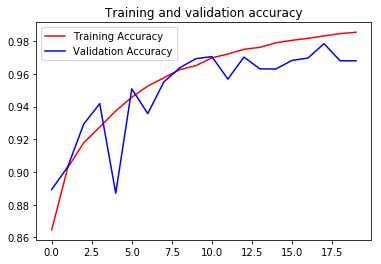

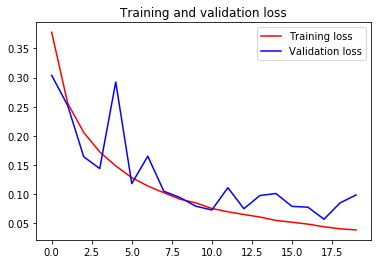

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### TEST 1

In [0]:
X_test, y_test, predictions, test_images, test_masks = get_test_image('./tumor_091.tif','./tumor_091_mask.tif',model_conv_scratch)
calc_metrics(y_test,predictions)

(34056, 150, 150, 3)
34056/34056 [==============================] - 15s 443us/step

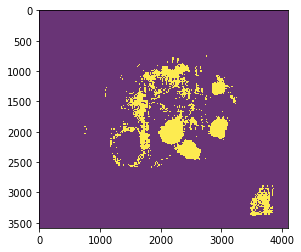

In [0]:
predicted_mask = get_heatmap(test_images, predictions, model_conv_scratch)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)

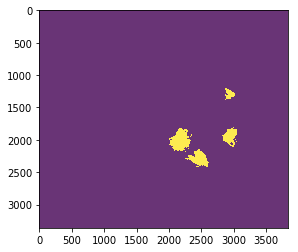

In [0]:
mask_region = get_mask('../vatsala-adl/tumor_091_mask.tif',4)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)

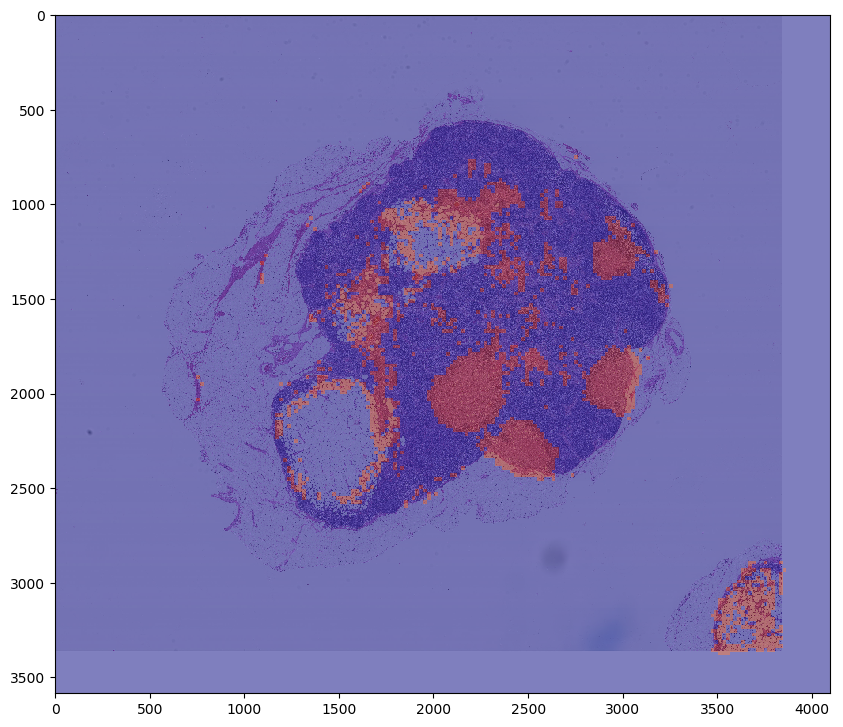

In [0]:
overlay('../vatsala-adl/tumor_091.tif', 4, predicted_mask )

### TEST 2

(66900, 150, 150, 3)
66900/66900 [==============================] - 29s 437us/step

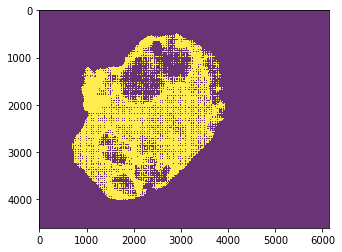

In [0]:
X_test, y_test, predictions, test_images, test_masks = get_test_image('../vatsala-adl/tumor_110.tif','../vatsala-adl/tumor_110_mask.tif',model_conv_scratch)
calc_metrics(y_test,predictions)
predicted_mask = get_heatmap(test_images, predictions, model_conv_scratch)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)

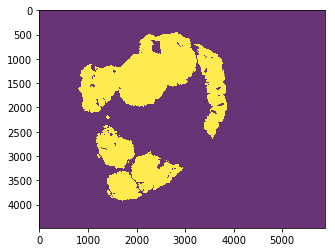

In [0]:
mask_region = get_mask('../vatsala-adl/tumor_110_mask.tif',4)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)

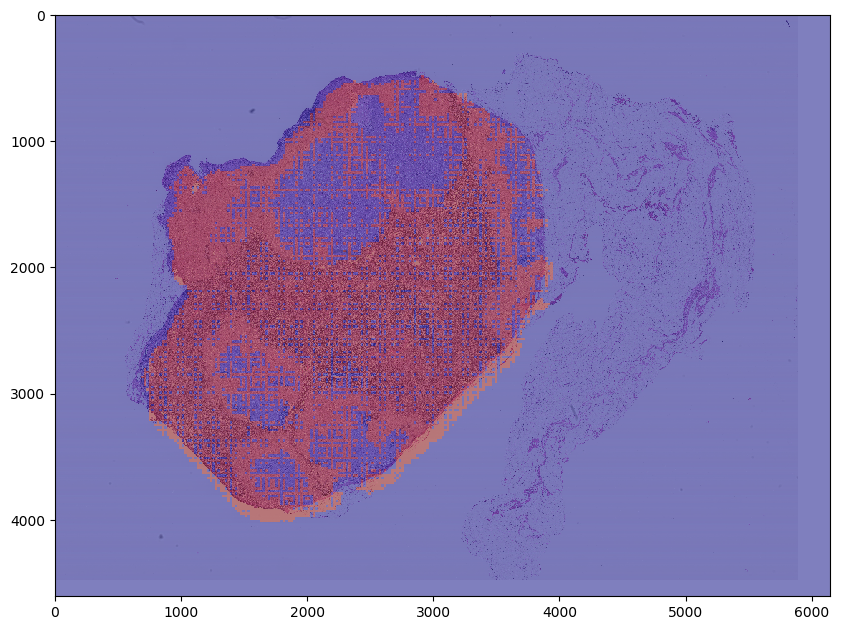

In [0]:
overlay('../vatsala-adl/tumor_110.tif', 4, predicted_mask )

### TEST 3 

In [0]:
X_test, y_test, predictions, test_images, test_masks = get_test_image('../vatsala-adl/tumor_096.tif','../vatsala-adl/tumor_096_mask.tif',model_conv_scratch)
calc_metrics(y_test,predictions)


(89869, 150, 150, 3)
89869/89869 [==============================] - 41s 454us/step

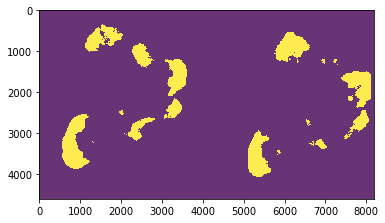

In [0]:
predicted_mask = get_heatmap(test_images, predictions, model_conv_scratch)
plt.imshow(predicted_mask,cmap='viridis', vmin=0, vmax=1, alpha=0.8)

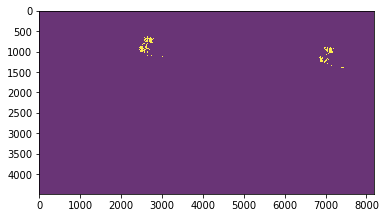

In [0]:
mask_region = get_mask('../vatsala-adl/tumor_096_mask.tif',4)
plt.imshow(mask_region, cmap='viridis', vmin=0, vmax=1, alpha=0.8)

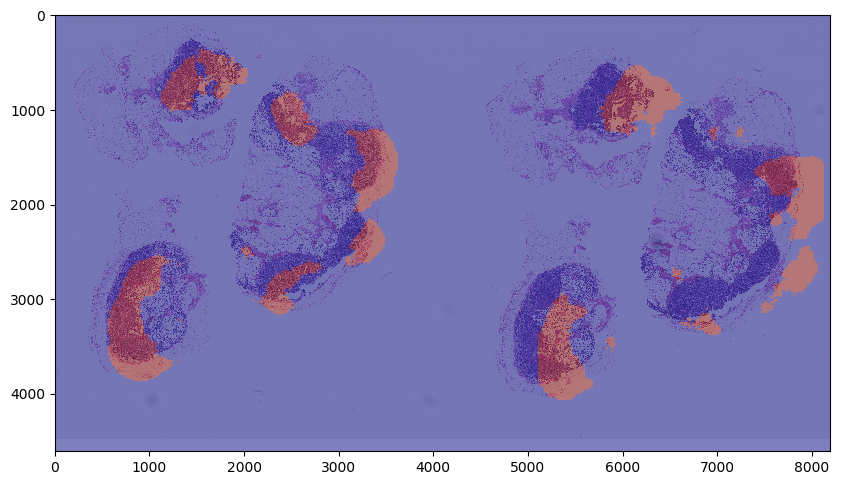

In [0]:
overlay('../vatsala-adl/tumor_096.tif', 4, predicted_mask )

## Analysis

The transfer learning output is comparable to the CNN output. In most cases, the CNN has a higher recall but lower precision (due to the high number of false positives) as compared to transfer model. 

Overall, the level 4 models perform much better than the level 5 magnification models, as is expected (since they have more contextual data). 

Again, we note that the CNN produces comparable results with much lower number of parameterrs as compared to transfer learning. 